In [1]:
import cv2
from PIL import Image,ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import math

#path to a test colour and grayscale image
test_im_path = '/home/daniel/Documents/4yp/Datasets/gtFine/train/bremen/bremen_000004_000019_gtFine_color.png'
test_bw_path = '/home/daniel/Documents/4yp/Datasets/gtFine/train/bremen/bremen_000004_000019_gtFine_labelIds.png'

### Create matplotlib inline plotting function

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (25.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def plot_subplot(ims):
    num_im = len(ims)
    x_grid = math.floor(num_im**0.65)
    y_grid = math.ceil(num_im**0.65)
    for idx,im in enumerate(ims,start=1):
        plt.subplot(y_grid,x_grid,idx)
        plt.imshow(im.astype('uint8'))
        plt.axis('off')
    plt.show()

#function for plotting either single image or list of images
## TODO: make this zip ims, then no conditional statements required
def plot(ims):
    if isinstance(ims,list):
        plot_subplot(ims)
    else:
        plot_subplot([ims])

In [15]:
#PIL functionality for getting a touple of (count, colour)
## TODO: use the count variable when reordering sizes
def get_cols(im):
    pil_im = Image.fromarray(im)
    colours = pil_im.getcolors()
    return colours

In [16]:
def make_one_hots(im, opts=None):
    ''' 
    seperate images by distinct labels
    arguments: im - ndarray shape (h,w,c)
                 with im[i,j,:] having n_label unique values
    returns: hots - ndarray shape (nlabel,h,w)
             col_list - list of colours associated with each layer
    '''
    
    #this works well for rgb images, but not for bw images of shape (h,w)
    #get colours and re-order them by size
    colours = get_cols(im)
    colours = sorted(colours,key=lambda x:-x[0])
    
    if opts:
        n_label = opts.n_label
    else:
        #n_label = len(colours)
        n_label = 35
    
    
    hots = np.zeros((n_label,im.shape[0],im.shape[1])) # return size n_label, h, w
    col_array = np.zeros(n_label, dtype='int')
    #print('im dim: ', im.shape)
    for idx,colour_tups in enumerate(colours):
        colour = colour_tups[1]
        cm,i = get_col_map(im,colour,idx)
        col_array[i] = colour
        hots[i,:,:] = cm
        
    return hots.astype('uint8'),col_array

def get_col_map(im,colour,idx):
    #unpack values
    dims = len(im.shape)
    
    if dims == 3:
        red,green,blue = im.T
        target_red,target_green,target_blue = colour
        colour_map = (red == target_red) & (green == target_green) & (blue == target_blue)
        return 255*colour_map,idx
    elif dims == 2:
        colour_map = im == colour
        return 255*colour_map,colour
    
    raise ValueError('unknown dimension')        

In [17]:
# test gluing 
# use this weird imread
from skimage import io
bw = io.imread(test_bw_path)
print('og im dtype: {}, size: {}'.format(bw.dtype, bw.shape))

#got the image, now to make it hot
hots,colours = make_one_hots(bw)

print('hots dtype: {}, size: {}'.format(hots.dtype, hots.shape))
print(colours)
#split it into a list
## TODO don't use a list here
hot_list = [h[0] for h in np.split(hots,hots.shape[0])]

print(hot_list[0].shape)

og im dtype: uint8, size: (1024, 2048)
hots dtype: uint8, size: (35, 1024, 2048)
[ 0  1  0  3  4  5  6  7  8  0  0 11  0  0  0  0  0 17  0 19 20 21  0 23
 24 25 26  0  0  0  0 31  0 33  0]
(1024, 2048)


In [18]:
def paint_bound_rects(hot):
    im2, contours, _ = cv2.findContours(hot,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(f'so many contours: {len(contours)}')
    
    boxes = np.zeros_like(hot)
    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(boxes,[box],-1,(127),-1)
    
    return boxes

def bound_distort(hot):
    '''
    input    one hot binary image
    output   blocky one hot binary image
    '''
    
    ker = np.ones((15,15),np.uint8)
    mod_hot = cv2.dilate(hot,ker,iterations=1)
    
    boxes = paint_bound_rects(mod_hot)
    
    smol_boxes = cv2.erode(boxes,ker,iterations=2)
    return boxes
    #plot(cv2.add(boxes,hot))    
    #plot(cv2.drawContours(np.zeros_like(hot),contours,-1,(255),3))
    
def distort_array(hots,no_distort=[]):
    num_lay = hots.shape[0]
    dis_array = np.zeros_like(hots)
    layer_list = np.split(hots,num_lay)
    dis_gen = (bound_distort(l[0]) if i not in no_distort else l[0] for i,l in enumerate(layer_list))
    dis_array = np.stack(dis_gen)
    return dis_array

(35, 1024, 2048)


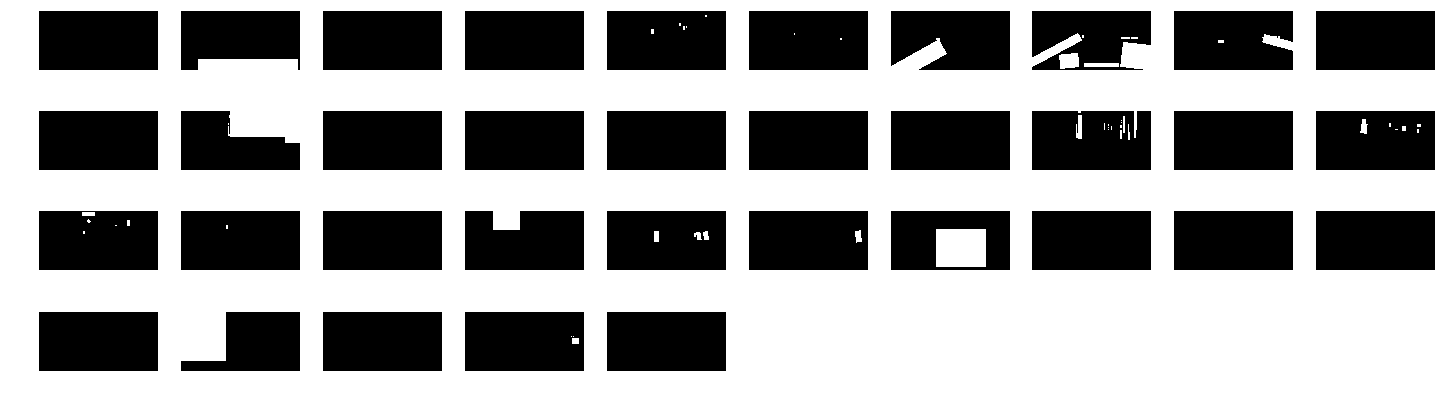

In [19]:
#test bound distort for multi layer ims
print(hots.shape)
bound_hots = distort_array(hots)
plot([h[0] for h in np.split(bound_hots,35)])

In [40]:
import os

def make_train_arrays(im_dir):
    
    paths = os.listdir(im_dir)
    try:
        paths.remove('results')
    except ValueError:
        print('not made results dir yet')
        os.mkdir(os.path.join(im_dir,'results'))
    
    try:
        paths.remove('results_np')
    except ValueError:
        print('not made results_np dir yet')
        os.mkdir(os.path.join(im_dir,'results_np'))
        
    total = len(paths)
    for i,path in enumerate(paths):
        hots,_ = make_one_hots(io.imread(os.path.join(im_dir,path)))
        foto = distort_array(hots)
        save_path = os.path.join(im_dir, 'results_np',path.strip('.png') + '_distorted_np') #set meaningful name
        np.savez_compressed(save_path,foto)
        if i%50==0:
            print('Done {}%'.format(i/total*100))
            #print('img processing time: {}, disk writing time: {}'.format(loop_time,save_time))

In [41]:
make_train_arrays('/home/daniel/Documents/4yp/py_utils/image_preproc/test_dir_2')

Done 0.0%


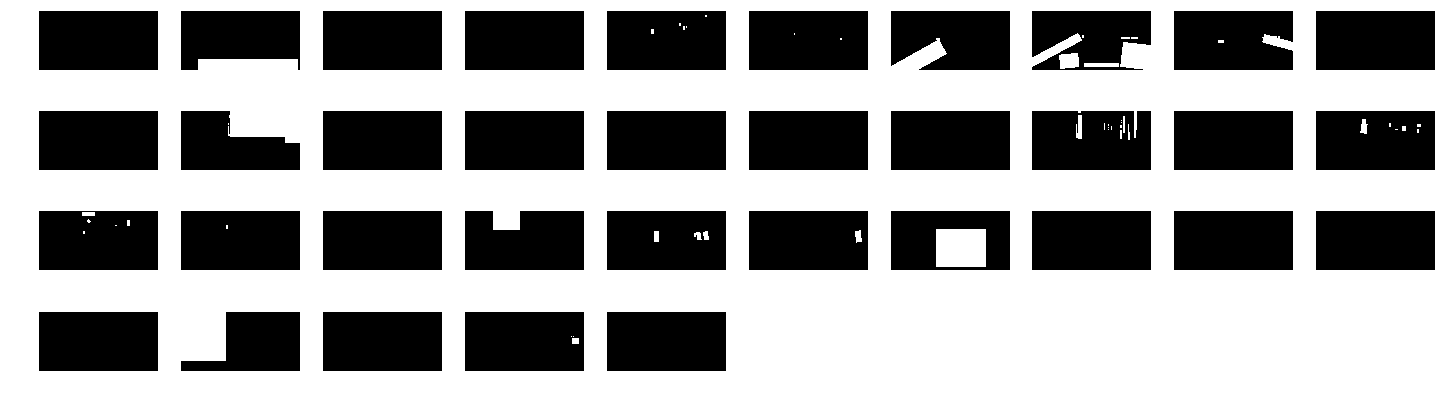

In [29]:
#recall saved array

loaded = np.load('/home/daniel/Documents/4yp/py_utils/image_preproc/test_dir_2/results_np/bremen_000004_000019_gtFine_labelIds_distorted_np.npz')
plot([h[0] for h in np.split(loaded['arr_0'],35)])

In [42]:
#blindly try the real thing
make_train_arrays('/home/daniel/Documents/4yp/Datasets/gtFine/train/instance_only')

Done 0.0%
Done 1.680672268907563%
Done 3.361344537815126%
Done 5.042016806722689%
Done 6.722689075630252%
Done 8.403361344537815%
Done 10.084033613445378%
Done 11.76470588235294%
Done 13.445378151260504%
Done 15.126050420168067%
Done 16.80672268907563%
Done 18.487394957983195%
Done 20.168067226890756%
Done 21.84873949579832%
Done 23.52941176470588%
Done 25.210084033613445%
Done 26.89075630252101%
Done 28.57142857142857%
Done 30.252100840336134%
Done 31.932773109243694%
Done 33.61344537815126%
Done 35.294117647058826%
Done 36.97478991596639%
Done 38.655462184873954%
Done 40.33613445378151%
Done 42.016806722689076%
Done 43.69747899159664%
Done 45.378151260504204%
Done 47.05882352941176%
Done 48.739495798319325%
Done 50.42016806722689%
Done 52.10084033613446%
Done 53.78151260504202%
Done 55.46218487394958%
Done 57.14285714285714%
Done 58.82352941176471%
Done 60.50420168067227%
Done 62.18487394957983%
Done 63.86554621848739%
Done 65.54621848739495%
Done 67.22689075630252%
Done 68.907563025

In [ ]:
def distort_one_layer

In [8]:
#distort n layers, chosen randomly

def distort_n(hot_list,n):
    assert n<=len(hot_list)
    num_layers = len(hot_list)
    choices = np.zeros(num_layers)
    indices_to_distort = np.random.choice(num_layers,n)
    choices[indices_to_distort] = 1
    
    return [bound_distort(hot) if choices[idx] else hot for idx,hot in enumerate(hot_list)]

In [9]:
#DEPRECATED - no longer using lists of layers, this is numpy town baby

def plot_difference(normal, distorted):
    '''
    plot differences between distorted and undistorted layers
    '''
    blue = np.zeros_like(normal[0])
    diffs = []
    for n,d in zip(normal,distorted):
        im = np.dstack((d,n,blue)).astype('uint8')
        diffs += [im]
    
    plot(diffs)

idx = 0
plot_difference(hot_list[idx:idx+4],bd_list[idx:idx+4])

NameError: name 'hot_list' is not defined

In [10]:
from bisect import bisect_left

def get_order(lc):
    #get tuple of size x layer
    
    sizes = []
    ordered_l = []
    ordered_c = []
    for l,c in lc:
        size = l[l>0].size
        idx = bisect_left(sizes,size)
        sizes.insert(idx,size)
        ordered_l.insert(-idx,l)
        ordered_c.insert(-idx,c)
        
    #print('dis whats coming back')    
    #plot(ordered)
    return ordered_l,ordered_c
    
def glue(layers,colours):
    n_layers = len(layers)
    h = layers[0].shape[0]
    w = layers[0].shape[1]
    
    final_img = np.zeros((h,w,3))
    
    ordered_layers,ordered_colours = get_order(zip(layers,colours))
    
    for layer,colour in zip(ordered_layers,ordered_colours):
        broadcast_colour = (np.array(colour)[:,np.newaxis,np.newaxis])
        one_layer = 1*(layer>0)
        new_lay = (one_layer*broadcast_colour).astype('float64') # h,w * 3
        new_lay = np.swapaxes(new_lay.T,0,1)
        
        #enable for funky graphics
        #new_lay = cv2.GaussianBlur(new_lay,(31,31),0)
        
        #overlay where image exists
        mask = new_lay.sum(axis=2)>0
        
        # change to += for funky graphics
        final_img[mask,:] = new_lay[mask,:]
        #final_img = cv2.GaussianBlur(final_img,(3,3),0)
        #final_img = cv2.add(final_img,new_lay)
        
    return final_img

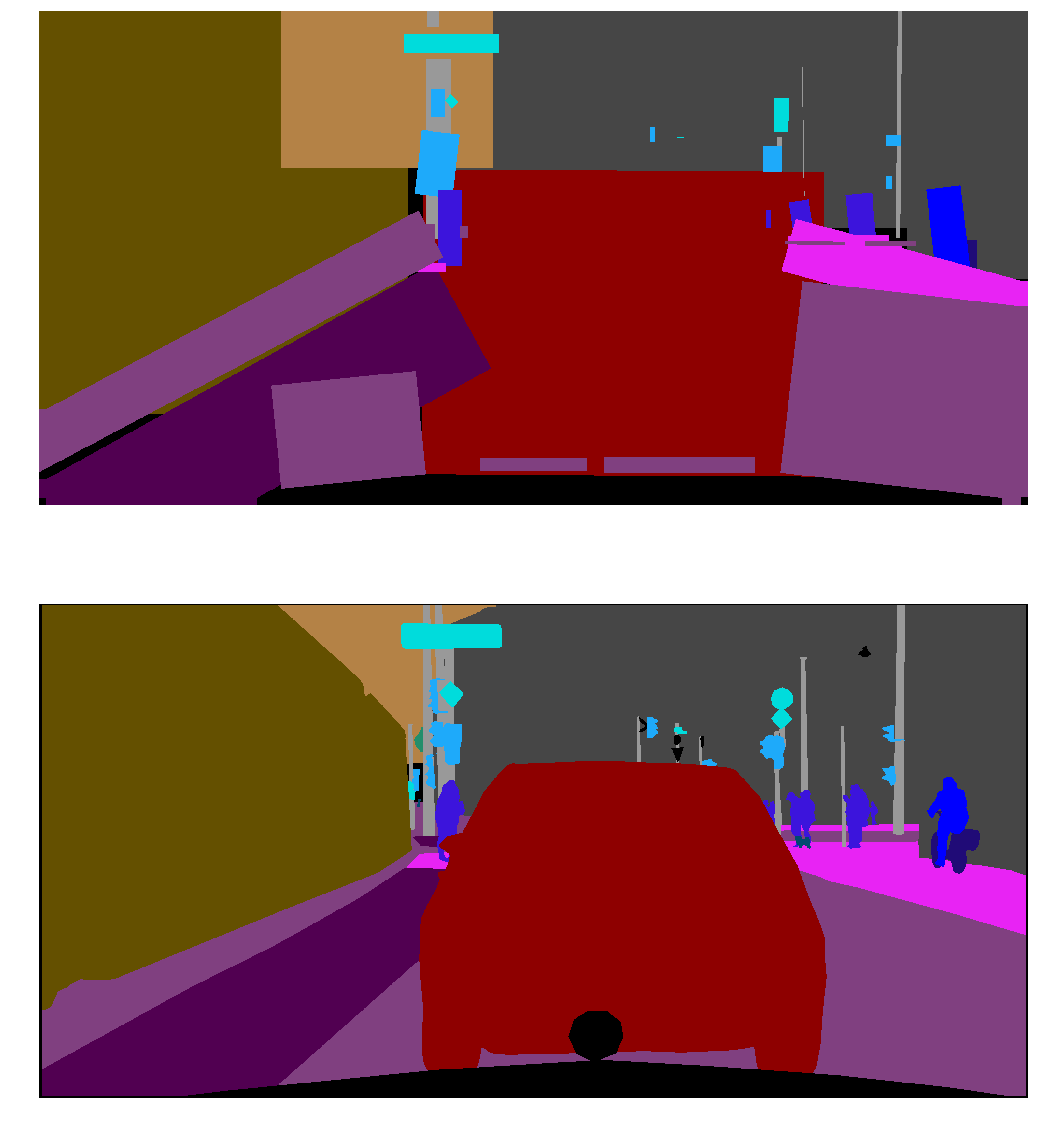

In [24]:
result = glue(bd_list,colours)
#plot(sep_l)
plot([result, seps])

In [26]:
def quantize(im):
    #limit the num of colours to less than 256 or otherwise it doesn't work
    #would be cool for normal images
    #not required for label maps
    quantized = im
    return quantized

In [63]:
def preproc(im):
    quantized = quantize(im)
    hots,cols = make_one_hots(quantized)
    return [h[0] for h in np.split(hots,hots.shape[0])]

In [64]:
def create_distorted_im(im,n_distort = None):
    #in this method, when creating distorted, do something to only distort one layer
    
    label_list = preproc(im)
    if n_distort is None:
        distorted = [bound_distort(hot) for hot in label_list]
    else:
        distorted = distort_n(label_list, n_distort)
    result = glue(distorted,cols)
    return result

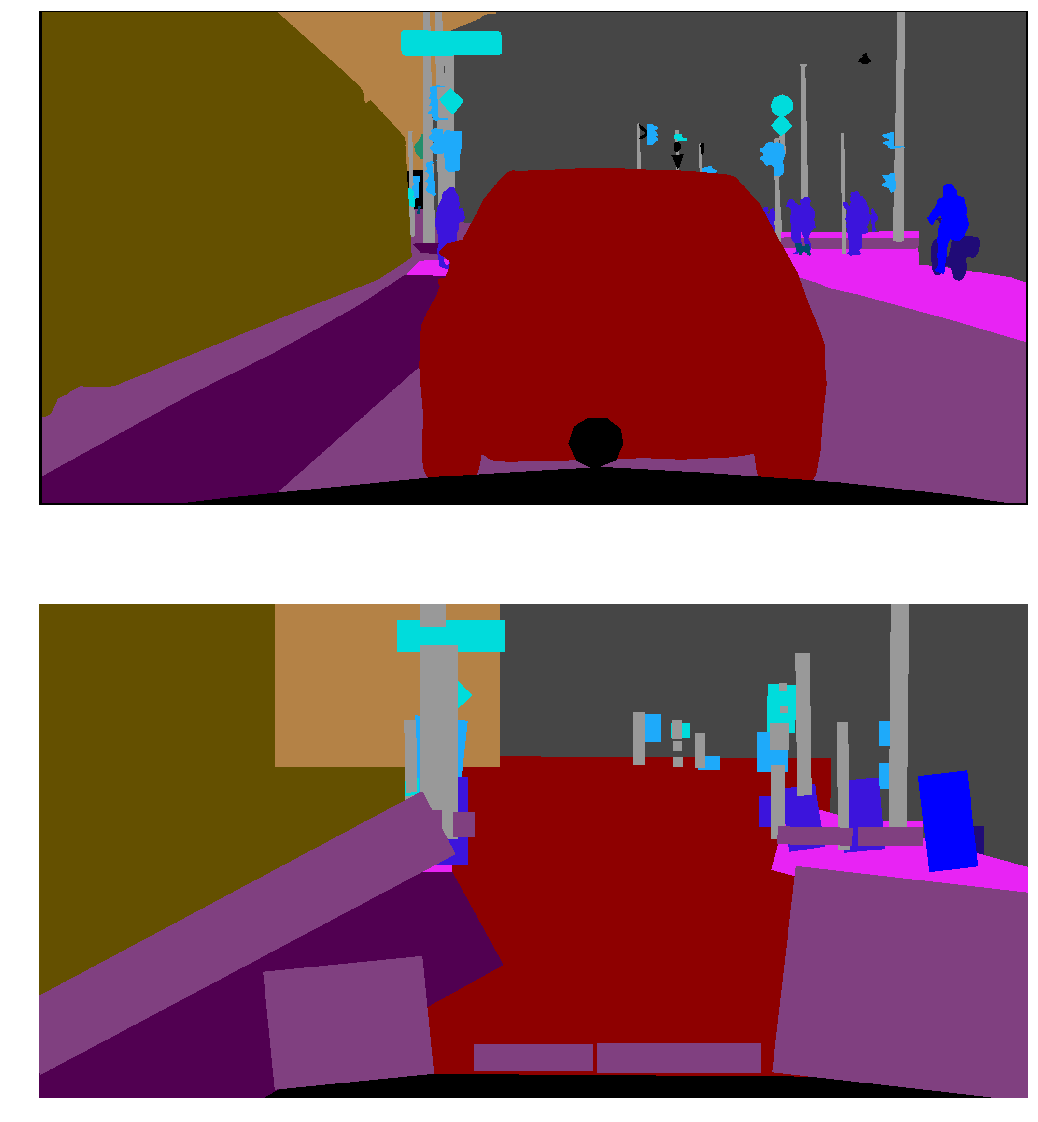

In [57]:
test_im = get_im(test_im_path)
distorted_cityscapes = create_distorted_im(test_im)

plot([test_im,distorted_cityscapes])

In [61]:
from os import listdir

def distort_directory(im_dir):
    #get list of addresses
    path_list = listdir(im_dir)
    im_list = []
    total = len(path_list)
    path_list.remove('results')
    
    for idx,f_name in enumerate(path_list):
        if idx%10==0:
            perc = (idx/total*100)
            print(f'{perc}% done')
        path = im_dir + '/' + f_name
        #print(path)
        im = get_im(path)
        distorted_im = create_distorted_im(im)
        name = im_dir + '/results/' + f_name.strip('.png') + '_distorted.png' #set meaningful name
        #print('processed, saving to : ', name)
        #print()
        #im_list += [distorted_im]
        cv2.imwrite(name, distorted_im)
        
    #plot(im_list)

In [ ]:
distort_directory('/home/daniel/Documents/4yp/py_utils/image_preproc/test_dir')

In [62]:
distort_directory('/home/daniel/Documents/4yp/Datasets/gtFine/train/instance_only')

0.0% done
0.33602150537634407% done
0.6720430107526881% done
1.0080645161290323% done
1.3440860215053763% done
1.6801075268817203% done
2.0161290322580645% done
2.3521505376344085% done
2.6881720430107525% done
3.024193548387097% done
3.3602150537634405% done
3.696236559139785% done
4.032258064516129% done
4.368279569892473% done
4.704301075268817% done
5.040322580645161% done
5.376344086021505% done
5.712365591397849% done
6.048387096774194% done
6.384408602150538% done
6.720430107526881% done
7.056451612903227% done
7.39247311827957% done
7.728494623655914% done
8.064516129032258% done
8.400537634408602% done
8.736559139784946% done
9.07258064516129% done
9.408602150537634% done
9.744623655913978% done
10.080645161290322% done
10.416666666666668% done
10.75268817204301% done
11.088709677419354% done
11.424731182795698% done
11.760752688172044% done
12.096774193548388% done
12.432795698924732% done
12.768817204301076% done
13.104838709677418% done
13.440860215053762% done
13.776881720

In [ ]:
def one_blocky_on_top(im):
    labels = preproc(im)